# Multi-Layer Perceptron (MLP) Neural Networks

## What is an MLP?

A Multi-Layer Perceptron is the simplest form of artificial neural network:
- Consists of input layer, hidden layers, and output layer
- Each neuron is connected to all neurons in the next layer (fully connected)
- Uses activation functions to introduce non-linearity
- Learns through backpropagation

Think of it as a universal function approximator - it can learn complex patterns in data!

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification, make_regression, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Libraries loaded successfully!")

Using device: cpu
Libraries loaded successfully!


## Understanding Neural Network Architecture

Let's visualize what an MLP looks like:

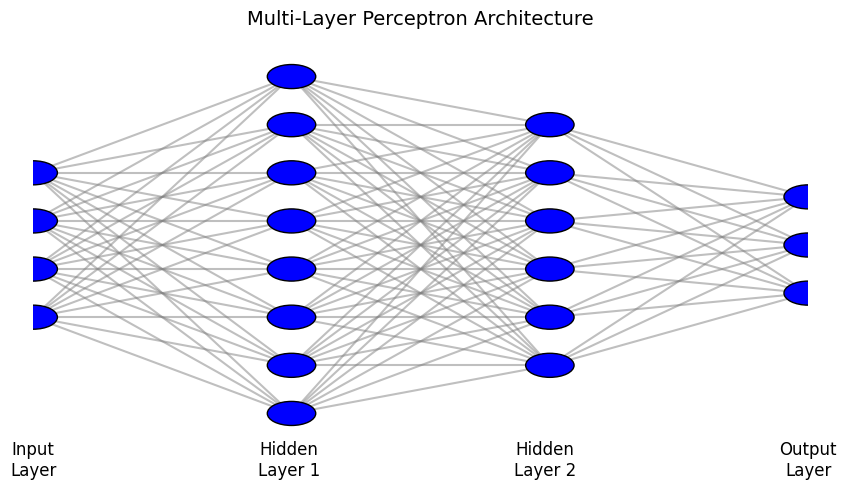

In [2]:
# Visualize a simple MLP architecture
def draw_neural_net(ax, layer_sizes):
    '''Draw a neural network cartoon using matplotlib.'''
    n_layers = len(layer_sizes)
    v_spacing = 1.0 / max(layer_sizes)
    h_spacing = 1.0 / (n_layers - 1)
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2.0 + 0.5
        for m in range(layer_size):
            circle = plt.Circle((n * h_spacing, layer_top - m * v_spacing), 
                              v_spacing / 4.0, color='blue', ec='k', zorder=4)
            ax.add_artist(circle)
    
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2.0 + 0.5
        layer_top_b = v_spacing * (layer_size_b - 1) / 2.0 + 0.5
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n * h_spacing, (n + 1) * h_spacing],
                                [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing], 
                                c='gray', alpha=0.5)
                ax.add_artist(line)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, [4, 8, 6, 3])
ax.text(0, -0.1, 'Input\nLayer', ha='center', fontsize=12)
ax.text(0.33, -0.1, 'Hidden\nLayer 1', ha='center', fontsize=12)
ax.text(0.66, -0.1, 'Hidden\nLayer 2', ha='center', fontsize=12)
ax.text(1, -0.1, 'Output\nLayer', ha='center', fontsize=12)
plt.title('Multi-Layer Perceptron Architecture', fontsize=14, pad=20)
plt.show()

## Part 1: Classification with MLP

We'll use the digits dataset - recognizing handwritten digits (0-9).

Dataset shape: (1797, 64)
Number of classes: 10
Image dimensions: 8x8 pixels (flattened to 64 features)


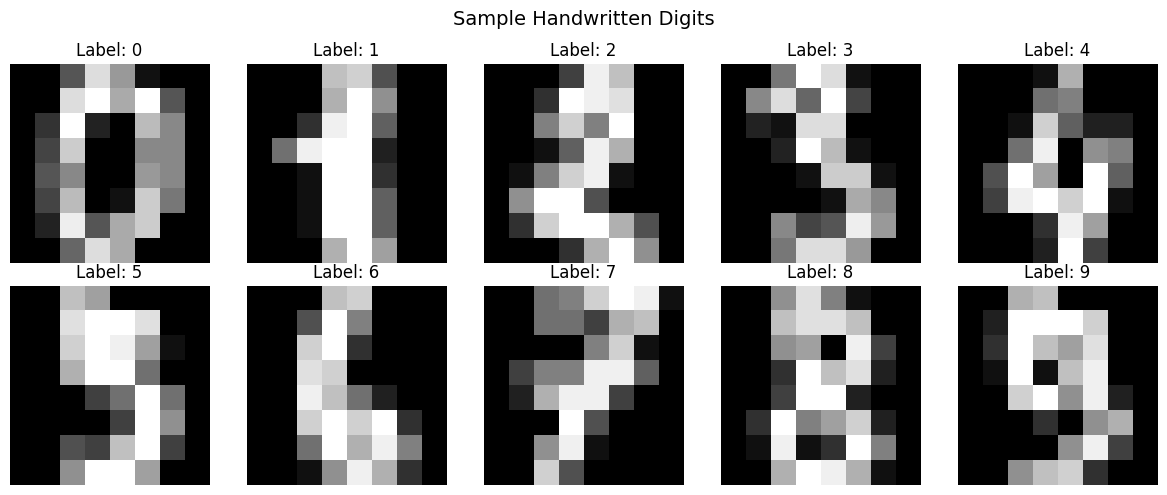

In [3]:
# Load the digits dataset
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# Each image is 8x8 pixels
print(f"Dataset shape: {X_digits.shape}")
print(f"Number of classes: {len(np.unique(y_digits))}")
print(f"Image dimensions: 8x8 pixels (flattened to {X_digits.shape[1]} features)")

# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Label: {y_digits[i]}')
    ax.axis('off')
plt.suptitle('Sample Handwritten Digits', fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
# Prepare the data
# Normalize the features
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_digits_scaled, y_digits, test_size=0.2, random_state=42, stratify=y_digits
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 1437
Test samples: 360


In [5]:
# Define the MLP model for classification
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLPClassifier, self).__init__()
        
        # Build the layers
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.Dropout(0.2))  # Dropout for regularization
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Create the model
model_class = MLPClassifier(
    input_size=64,  # 8x8 pixels
    hidden_sizes=[128, 64],  # Two hidden layers
    num_classes=10  # Digits 0-9
).to(device)

print("Model architecture:")
print(model_class)

Model architecture:
MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [6]:
# Training function
def train_model(model, train_loader, test_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        accuracy = 100 * correct / total
        train_losses.append(epoch_loss / len(train_loader))
        test_accuracies.append(accuracy)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Test Accuracy: {accuracy:.2f}%')
    
    return train_losses, test_accuracies

# Train the model
print("Training the classification model...")
train_losses, test_accuracies = train_model(model_class, train_loader, test_loader)

Training the classification model...
Epoch [10/50], Loss: 0.0658, Test Accuracy: 97.78%
Epoch [20/50], Loss: 0.0171, Test Accuracy: 98.33%
Epoch [30/50], Loss: 0.0127, Test Accuracy: 97.22%
Epoch [40/50], Loss: 0.0044, Test Accuracy: 98.61%
Epoch [50/50], Loss: 0.0073, Test Accuracy: 98.89%


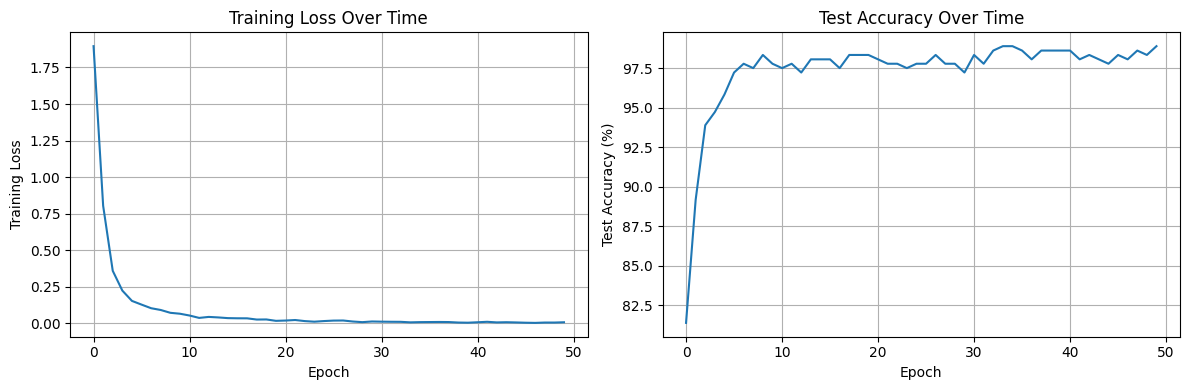

Final test accuracy: 98.89%


In [7]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Over Time')
ax1.grid(True)

ax2.plot(test_accuracies)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Accuracy (%)')
ax2.set_title('Test Accuracy Over Time')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final test accuracy: {test_accuracies[-1]:.2f}%")

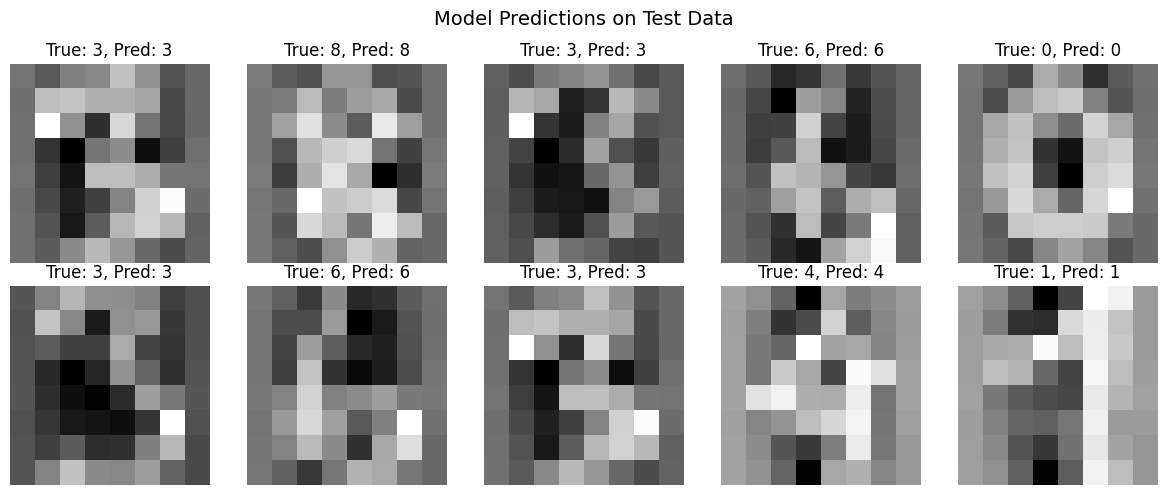

In [8]:
# Visualize some predictions
model_class.eval()
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        idx = np.random.randint(0, len(X_test))
        
        # Get prediction
        input_tensor = X_test_tensor[idx].unsqueeze(0).to(device)
        output = model_class(input_tensor)
        _, predicted = torch.max(output, 1)
        
        # Show image
        img = X_test[idx].reshape(8, 8)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {y_test[idx]}, Pred: {predicted.item()}')
        ax.axis('off')

plt.suptitle('Model Predictions on Test Data', fontsize=14)
plt.tight_layout()
plt.show()

## Part 2: Regression with MLP

Now let's use an MLP for regression - predicting continuous values.

In [9]:
# Generate synthetic regression data
X_reg, y_reg = make_regression(n_samples=1000, n_features=10, n_informative=7, 
                               noise=10, random_state=42)

# Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_reg_scaled = scaler_X.fit_transform(X_reg)
y_reg_scaled = scaler_y.fit_transform(y_reg.reshape(-1, 1)).flatten()

# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg_scaled, test_size=0.2, random_state=42
)

# Convert to tensors
X_train_reg_tensor = torch.FloatTensor(X_train_reg)
y_train_reg_tensor = torch.FloatTensor(y_train_reg)
X_test_reg_tensor = torch.FloatTensor(X_test_reg)
y_test_reg_tensor = torch.FloatTensor(y_test_reg)

# Create DataLoaders
train_reg_dataset = TensorDataset(X_train_reg_tensor, y_train_reg_tensor)
test_reg_dataset = TensorDataset(X_test_reg_tensor, y_test_reg_tensor)

train_reg_loader = DataLoader(train_reg_dataset, batch_size=32, shuffle=True)
test_reg_loader = DataLoader(test_reg_dataset, batch_size=32, shuffle=False)

print(f"Regression dataset created:")
print(f"Features: {X_reg.shape[1]}")
print(f"Training samples: {len(X_train_reg)}")
print(f"Test samples: {len(X_test_reg)}")

Regression dataset created:
Features: 10
Training samples: 800
Test samples: 200


In [10]:
# Define MLP for regression
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLPRegressor, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size
        
        # Output layer (single value for regression)
        layers.append(nn.Linear(prev_size, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x).squeeze()

# Create the regression model
model_reg = MLPRegressor(
    input_size=10,
    hidden_sizes=[64, 32, 16]
).to(device)

print("Regression model architecture:")
print(model_reg)

Regression model architecture:
MLPRegressor(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [11]:
# Training function for regression
def train_regression_model(model, train_loader, test_loader, num_epochs=100):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Evaluation
        model.eval()
        epoch_test_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                epoch_test_loss += loss.item()
        
        train_losses.append(epoch_train_loss / len(train_loader))
        test_losses.append(epoch_test_loss / len(test_loader))
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    
    return train_losses, test_losses

# Train the regression model
print("Training the regression model...")
train_losses_reg, test_losses_reg = train_regression_model(model_reg, train_reg_loader, test_reg_loader)

Training the regression model...
Epoch [20/100], Train Loss: 0.0994, Test Loss: 0.0373
Epoch [40/100], Train Loss: 0.0872, Test Loss: 0.0339
Epoch [60/100], Train Loss: 0.0770, Test Loss: 0.0225
Epoch [80/100], Train Loss: 0.0769, Test Loss: 0.0365
Epoch [100/100], Train Loss: 0.0724, Test Loss: 0.0279


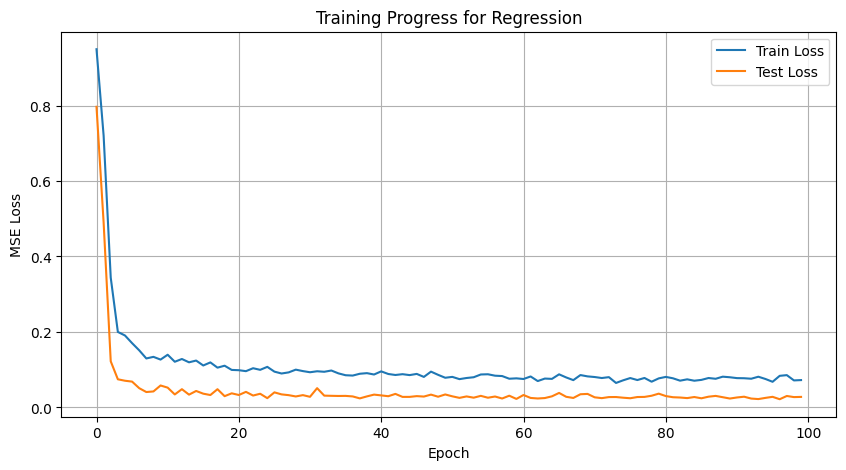

In [12]:
# Plot regression training progress
plt.figure(figsize=(10, 5))
plt.plot(train_losses_reg, label='Train Loss')
plt.plot(test_losses_reg, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress for Regression')
plt.legend()
plt.grid(True)
plt.show()

Test MSE: 0.0287
Test R² Score: 0.9706


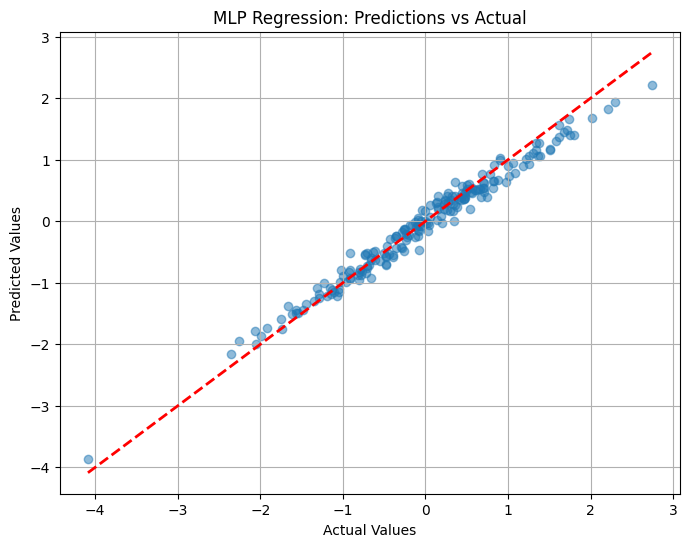

In [13]:
# Evaluate regression model
model_reg.eval()
with torch.no_grad():
    predictions = model_reg(X_test_reg_tensor.to(device)).cpu().numpy()

# Calculate metrics
mse = mean_squared_error(y_test_reg, predictions)
r2 = r2_score(y_test_reg, predictions)

print(f"Test MSE: {mse:.4f}")
print(f"Test R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, predictions, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('MLP Regression: Predictions vs Actual')
plt.grid(True)
plt.show()

## Key Concepts Explained

### 1. Activation Functions
- **ReLU (Rectified Linear Unit)**: Most common, helps with vanishing gradient
- **Sigmoid**: Outputs between 0 and 1, good for binary classification
- **Tanh**: Outputs between -1 and 1, centered at zero

### 2. Backpropagation
- Algorithm that calculates gradients efficiently
- Updates weights to minimize loss function
- Chain rule of calculus applied through the network

### 3. Regularization Techniques
- **Dropout**: Randomly "drops" neurons during training to prevent overfitting
- **Weight decay**: Penalizes large weights
- **Early stopping**: Stop training when validation performance plateaus

### 4. Optimization
- **SGD**: Basic gradient descent
- **Adam**: Adaptive learning rates, usually works well
- **Learning rate**: Controls step size in optimization

## Comparing MLP to XGBoost

### MLP Advantages:
- Can learn highly non-linear patterns
- Works well with unstructured data (images, text)
- Can be part of end-to-end learning systems

### MLP Disadvantages:
- Requires more data to train effectively
- Less interpretable than tree-based methods
- Sensitive to hyperparameters
- Requires careful preprocessing (normalization)

### When to Use MLP:
- Complex non-linear relationships
- Large amounts of data available
- As building blocks for more complex architectures
- When you need to learn representations

## Exercises

1. **Architecture Exploration**: Try different numbers of hidden layers and neurons
2. **Activation Functions**: Replace ReLU with Sigmoid or Tanh and compare
3. **Regularization**: Experiment with different dropout rates
4. **Learning Rate**: Try different learning rates and see the effect
5. **Batch Size**: Change batch size and observe training dynamics